In [64]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [65]:
newsdata = fetch_20newsgroups(subset="train")

newsdata.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [66]:
len(newsdata["data"])

11314

In [67]:
len(newsdata["target"])

11314

In [68]:
newsdata["target"][0]

7

In [69]:
newsdata["target_names"][newsdata["target"][0]] # 첫 번째 sample의 target_name

'rec.autos'

In [70]:
print(newsdata["data"][0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [71]:
data = pd.DataFrame(
    data=newsdata["data"],
    columns=["email"]
)
data["target"] = pd.Series(newsdata["target"])

data.head()

,email,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   11314 non-null  object
 1   target  11314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 176.9+ KB


In [73]:
data.isnull().any()

email     False
target    False
dtype: bool

<Axes: xlabel='target'>

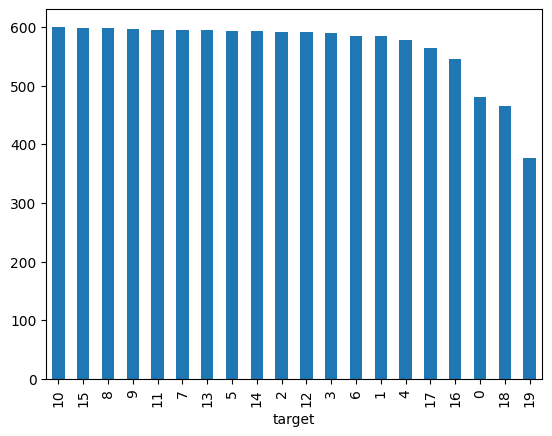

In [74]:
data["target"].value_counts().plot(kind="bar")

In [75]:
data["target"].value_counts()

target
10    600
15    599
8     598
9     597
11    595
7     594
13    594
5     593
14    593
2     591
12    591
3     590
6     585
1     584
4     578
17    564
16    546
0     480
18    465
19    377
Name: count, dtype: int64

In [76]:
newsdata_test = fetch_20newsgroups(subset="test", shuffle=True)
train_email = data["email"]
train_label = data["target"]
test_email = newsdata_test["data"]
test_label = newsdata_test["target"]

In [77]:
# 전처리 시작
vocab_size = 10_000 # 최대 단어 개수
num_classes = 20

def prepare_data(train_data, test_data, mode):
    tokenizer = Tokenizer(num_words=vocab_size) # 최대 단어 개수 지정
    tokenizer.fit_on_texts(train_data) # 정수 인코딩
    X_train = tokenizer.texts_to_matrix(train_data, mode=mode)
    X_test = tokenizer.texts_to_matrix(test_data, mode=mode)
    return X_train, X_test, tokenizer.index_word

In [78]:
X_train, X_test, idx_to_word = prepare_data(train_email, test_email, "binary") # binary 모드
y_train = to_categorical(train_label, num_classes)
y_test = to_categorical(test_label, num_classes)

In [79]:
print(f"훈련 샘플 본문의 크기: {X_train.shape}")
print(f"훈련 샘플 레이블의 크기: {y_train.shape}")
print(f"테스트 샘플 본문의 크기: {X_test.shape}")
print(f"테스트 샘플 레이블의 크기: {y_test.shape}")

훈련 샘플 본문의 크기: (11314, 10000)
훈련 샘플 레이블의 크기: (11314, 20)
테스트 샘플 본문의 크기: (7532, 10000)
테스트 샘플 레이블의 크기: (7532, 20)


In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def fit_and_evaluate(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(256, input_shape=(vocab_size, ), activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=0, validation_split=0.2)
    score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
    return score[1] # loss_val과 metrics_val 중 metrics_val 선택

In [81]:
modes = ["binary", "count", "tfidf", "freq"]

for mode in modes:
    X_train, X_test, _ = prepare_data(train_data=train_email, test_data=test_email, mode=mode)
    score = fit_and_evaluate(X_train, y_train, X_test, y_test)
    print(f"{mode}: {score}")

2023-07-10 21:17:04.007798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-10 21:17:05.259529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


binary: 0.8224906921386719


2023-07-10 21:17:14.543185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-10 21:17:15.767115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


count: 0.7989909648895264


2023-07-10 21:17:27.889019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-10 21:17:29.155721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


tfidf: 0.8219596147537231


2023-07-10 21:17:38.608514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-10 21:17:39.910119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


freq: 0.6480350494384766
